In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.optimize import curve_fit
from math import exp
from sklearn.metrics import r2_score
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import molecular_weight
from scipy.optimize import curve_fit
import cobra
from cobra.io import load_json_model
from rpafba import *

# pH of MRS medium as a function of lactic acid concentration

In [6]:
pHs =np.array([6.45,5.89,4.97,4.38,4.18,4.05,4.0,3.96])
lac_avg = np.array([0,4202.56, 17709.97333, 40312.08, 63108.98667, 68422.72, 81356.48, 94251.25333])
lac_std =np.array([0, 151.6281557, 525.3914066, 612.62024, 1631.616105, 1036.690386, 1082.426051, 2805.642163])
lac_avg = lac_avg/1000; lac_std = lac_std/1000; #mM

In [12]:
def approx_pH(x, k1,k2):
    return np.log(k1/(x+k2) )

popt, pcov = curve_fit( approx_pH, lac_avg, pHs )
print( popt )

[4438.84720759    7.621257  ]


/tmp/ipykernel_505/4018262767.py:2: RuntimeWarning: invalid value encountered in log
  return np.log(k1/(x+k2) )


0.9831462951680797


Text(20, 5.8, 'pH=$ln(\\frac{k_1}{[Lac]+k_2})$')

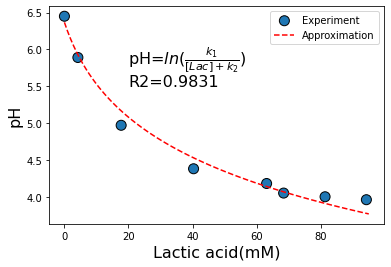

In [44]:
fig,ax = plt.subplots(1,1)
ax.scatter(lac_avg, pHs, linestyle='', marker='o', s=100, edgecolor='black',linewidth=10,label='Experiment')
temp_lacs = np.linspace(0,95,num=100)
ax.plot(temp_lacs, [approx_pH(x, 4438.85,7.62) for x in temp_lacs], linestyle='--',color='r',label='Approximation')
pH_preds = [ approx_pH(x, 4438.85,7.62) for x in lac_avg ]
print(r2_score(pH_preds,pHs ))
ax.set_ylabel('pH',fontsize=16)
ax.set_xlabel('Lactic acid(mM)',fontsize=16)
ax.legend()
ax.text(20,5.5,s='R2=0.9831',fontsize=16)
ax.text(20,5.8,s=r'pH=$ln(\frac{k_1}{[Lac]+k_2})$', fontsize=16)

# pH dependent enzyme activity (logistic function)

In [12]:
def sigmoid_func(x, k1, k2):
    return 1/(1+np.exp(-k1*(x-k2)))
def cubic_func(x, k1, k2):
    return k1*(x-k2)**3

ActpH = pd.read_csv('../data/Exp_data/pHvsEnzAct.csv')
enzymes = list( np.unique(ActpH['Enzyme']) )

In [13]:
params=[]
for enz in enzymes:
    xdata = np.array( list(ActpH[ActpH['Enzyme']==enz]['pH']) )
    ydata = np.array( list(ActpH[ActpH['Enzyme']==enz]['Activity']) )
    if enz in ['GAPD','PYK','MAN6PI','ACALD']:
        func_name = 'cubic'
        popt, pcov = curve_fit( cubic_func, xdata, ydata )
    else:
        func_name = 'sigmoid'
        popt, pcov = curve_fit( sigmoid_func, xdata, ydata )
        
    params.append( {'Enzyme':enz,'func_name':func_name,'k1':round(popt[0],4),'k2':round(popt[1],4) } )
params_pd = pd.DataFrame(params)

params_pd.to_csv('../data/GSMM_parameters/pH_EnzA.csv', index=None)

/tmp/ipykernel_1853/1302224051.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-k1*(x-k2)))


In [14]:
params_pd

,Enzyme,func_name,k1,k2
0,ACALD,cubic,0.0007,-4.0476
1,ENO,sigmoid,2.8696,6.2766
2,FDPA,sigmoid,3.5971,6.1339
3,GAPD,cubic,0.2120,4.7383
4,HEX,sigmoid,2.1451,6.2763
5,LACZ,sigmoid,1.0604,5.0921
6,LDH,sigmoid,4.5132,5.6809
7,MAN6PI,cubic,0.0037,0.9980
8,PFK,sigmoid,3.5910,5.7305
9,PGI,sigmoid,3.2329,5.9007


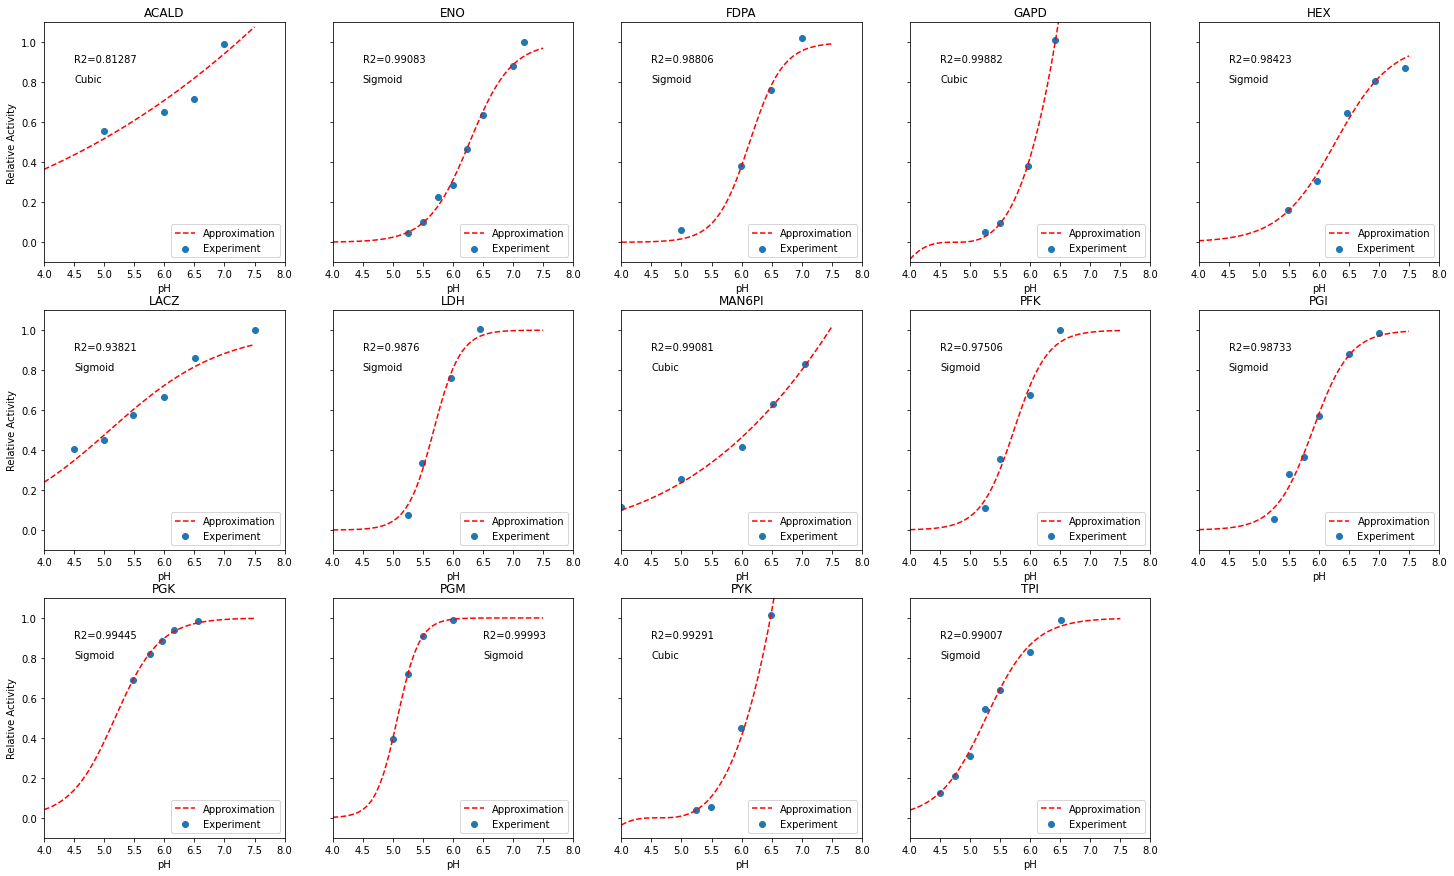

In [16]:
params_pd = pd.read_csv('../data/GSMM_parameters/pH_EnzA.csv')
fig, axs = plt.subplots(3,5,figsize=(25,15), sharey=True)
temp_x= np.linspace(4, 7.5)
for i in range(len(enzymes) ):
    x,y = int(i/5), int(i%5)
    temp_pd = ActpH[ActpH['Enzyme']==enzymes[i]]
    x_true, y_true = list(temp_pd['pH']), list(temp_pd['Activity'])
    param_data = params_pd[params_pd['Enzyme']== enzymes[i] ].values[0]
    func, k1, k2 = param_data[1], param_data[2], param_data[3]
    if func == 'sigmoid':
        axs[x][y].plot(temp_x, [sigmoid_func(x, k1, k2) for x in temp_x ],'--',color='r',label='Approximation' )
        y_pred = [sigmoid_func(x, k1, k2) for x in x_true]
    else:
        axs[x][y].plot(temp_x, [cubic_func(x, k1, k2) for x in temp_x ],'--',color='r', label='Approximation' )
        y_pred = [cubic_func(x, k1, k2) for x in x_true ]
    r2 = round( r2_score(y_pred,y_true ), 5)
    axs[x][y].scatter( x_true, y_true, label='Experiment')
    if enzymes[i] == 'PGM':
        axs[x][y].text(6.5, 0.9, 'R2='+str(r2))
    else:
        axs[x][y].text(4.5, 0.9, 'R2='+str(r2))
    if enzymes[i] in ['GAPD','PYK','MAN6PI','ACALD']:
        axs[x][y].text(4.5, 0.8, 'Cubic')
    elif enzymes[i] == 'PGM':
        axs[x][y].text(6.5, 0.8, 'Sigmoid')
    else:
        axs[x][y].text(4.5, 0.8, 'Sigmoid')
        
        
    axs[x][y].set_xlim([4,8.0])
    axs[x][y].set_ylim([-0.1,1.1])
    axs[x][y].set_title( enzymes[i] )
    axs[x][y].legend(loc='lower right')
    axs[x][y].set_xlabel('pH')
    if y== 0:
        axs[x][y].set_ylabel('Relative Activity')
    axs[2][4].set_visible(False)

# Generate inputs for kcat prediction

In [ ]:
# 'D-Xylulose 5-phosphate':,'D-Ribulose 5-phosphate':,'D-Fructose 6-phosphate':,'D-Mannose 6-phosphate':

In [3]:
# GT_locus = ['1_946','1_956','1_957','1_958','1_960','1_962','1_981','1_982']
# substrates = {'UDP-glucose':'C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)(O)OP(=O)(O)OC3C(C(C(C(O3)CO)O)O)O)O)O',
#               'UDP-galactose':'C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)(O)OP(=O)(O)OC3C(C(C(C(O3)CO)O)O)O)O)O',
#               'GDP-mannose':'C1=NC2=C(N1C3C(C(C(O3)COP(=O)(O)OP(=O)(O)OC4C(C(C(C(O4)CO)O)O)O)O)O)N=C(NC2=O)N'}
# eps_proteins = SeqIO.parse( "../data/Genome_HMX2/protein_hmx2.fa", "fasta")
# GT_seqs = {}
# for seq_record in eps_proteins:
#     if str(seq_record.id) in GT_locus:
#         GT_seqs[str(seq_record.id)] = str(seq_record.seq).replace('*','').strip() # remove *

In [4]:
# gt_ids, seqs, subs, smiles = [],[],[],[]
# for sugar in substrates.keys():
#     for gt_id in GT_seqs.keys():
#         gt_ids.append(gt_id)
#         seqs.append(GT_seqs[gt_id])
#         subs.append(sugar)
#         smiles.append(substrates[sugar])
# Ts = [float(37.0) for i in range(len(gt_ids))]
# input_pd = pd.DataFrame(zip(gt_ids,subs,seqs,smiles,Ts), \
#                 columns=['locus_tag','Substrate','seq','smiles','T'])

In [6]:
# def scale_minmax(array, x_min, x_max):
#     scaled_array = [(x-x_min)/(x_max-x_min) for x in array]
#     return scaled_array

# Temp_K = [ float(T+273.15) for T in list(input_pd['T']) ]
# Inv_Temp =  [ 1/float(T+273.15) for T in list(input_pd['T']) ]
# T_K_norm = scale_minmax( Temp_K, 273.15 , 373.15)
# inv_T_norm = scale_minmax( Inv_Temp, 1/373.15 , 1/273.15)
# input_pd['Temp_K_norm'] = T_K_norm
# input_pd['Inv_Temp_norm'] = inv_T_norm
# input_pd.to_csv('../data/GSMM_parameters/DL_input.csv',index=None)

In [14]:
pred_result = pd.read_csv('../data/GSMM_parameters/DL_output.csv')
pred_result['pred_kcat'] = [10**x for x in pred_result['pred_log10kcat'] ]
kcats = list(pred_result['pred_kcat'])
enz_mws = [molecular_weight(temp_seq, "protein") for temp_seq in list(pred_result['seq']) ]
sA = [kcats[i]*3600/enz_mws[i] for i in range(len(kcats))] #unit = mmol/(mg*hr)
pred_result['Activity'] = sA

In [19]:
print( np.average( pred_result[pred_result['Substrate']=='UDP-glucose']['Activity']) )
print( np.average( pred_result[pred_result['Substrate']=='GDP-mannose']['Activity']) )
print( np.average( pred_result[pred_result['Substrate']=='UDP-galactose']['Activity']) )

1.1216623825577834
1.2996388757465578
1.1216623825577834


# Estimate the activity of GTs

In [2]:
model = load_json_model('../data/GSMM_parameters/LP_HMX2.json')
ptot_lpl=0.299
pHs = [6.5, 5.5, 5, 4.5]
max_grs = {4.5: 0.33518078911208254, 5: 0.41737210588433693, 5.5: 0.4753825089522112, 6.5: 0.5886210431486689}
EPS_MW = model.metabolites.EPS_c.formula_weight
max_EPS_rates = {4.5: 232.0583306382854/EPS_MW, 5: 338.5890799468476/EPS_MW, 
                 5.5: 225.26467128479936/EPS_MW, 6.5: 160.84310034487967/EPS_MW} #mg to mmol
u_fracs={4.5:0.1671377966951495,5:0.1531718487568649,5.5:0.08519452202452667,6.5:0.08760784054764469}

[ -0.38150997   4.28474127 -11.03591954]
0.9972465207882047


Text(5, 0.65, 'Quadratic')

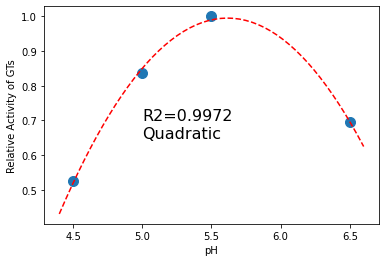

In [3]:
def quadratic(x,a,b,c):
    return a*x**2+b*x+c
approx_GT_A = {}
for pH in pHs:
    approx_GT_A[pH] = max_EPS_rates[pH]/(u_fracs[pH]*ptot_lpl)
max_value = max( approx_GT_A.values() )
for pH in pHs:
    approx_GT_A[pH] = approx_GT_A[pH]/max_value
popt, pcov = curve_fit( quadratic, list(approx_GT_A.keys()), list(approx_GT_A.values()) )
print(popt)
fig,ax=plt.subplots(1,1)
ax.scatter(approx_GT_A.keys(),approx_GT_A.values(), s=100)
temp_pHs=np.linspace(4.4,6.6)
pred_As = [quadratic(x,-0.3815,4.2847,-11.0359) for x in pHs]
print(r2_score(list(approx_GT_A.values()),pred_As ))
ax.plot(temp_pHs, [quadratic(x,-0.3815,4.2847,-11.0359) for x in temp_pHs], color='r',linestyle='--')
ax.set_xlabel('pH')
ax.set_ylabel('Relative Activity of GTs')
ax.text(5,0.7,s='R2=0.9972',fontsize=16)
ax.text(5,0.65,s='Quadratic',fontsize=16)

In [4]:
#at pH=6.5 without acid stress
GT_A_ranges=np.linspace(100,130,num=50)
params = load_model_params('../data/GSMM_parameters/model_params.csv')
MRS = init_MRSmedium()
FpH_table = pd.read_csv('../data/GSMM_parameters/FpH.csv')
def fba_nolac(model, params, pH, FpH_table):
    with model:
        model.medium = MRS
        set_LpPA( model, 0.299, params, 0, pH, FpH_table )
        fluxes = cobra.flux_analysis.pfba(model)
    return fluxes 

In [6]:
eps_rates = []
for GT_A in GT_A_ranges:
    temp_params = params.copy()
    temp_params['A']['MANT_EPS'] = GT_A
    temp_params['A']['GLCT_EPS'] = GT_A
    temp_params['A']['GALT_EPS'] = GT_A
    fluxes = fba_nolac(model, params, 6.5, FpH_table)
    eps_rates.append(fluxes.fluxes['WZX'])

Text(101, 0.048, 'pH=6.5 (no acid stress)')

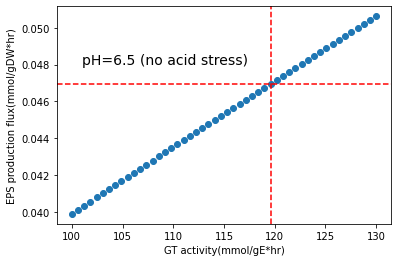

In [7]:
fig, ax = plt.subplots(1,1)
ax.scatter(GT_A_ranges, eps_rates)
ax.axhline(y=max_EPS_rates[6.5],color='red',ls='--')
ax.axvline(x=119.5918,color='red',ls='--')
ax.set_xlabel('GT activity(mmol/gE*hr)')
ax.set_ylabel('EPS production flux(mmol/gDW*hr)')
ax.text(101,0.048,s='pH=6.5 (no acid stress)',fontsize=14)

In [10]:
fluxes = fba_nolac(model, params, 4.2, FpH_table)
fluxes.fluxes['ACALD']
# flux_pd = fluxes.to_frame()
# flux_pd.to_csv('../data/Simulation_results/flux_4d2.csv')

7.063259577133217

In [13]:
fluxes = fba_nolac(model, params, 5.5, FpH_table)
fluxes.fluxes['biomass_LPL60']
fluxes.fluxes['EX_lac_L_e']

0.0

In [11]:
model.reactions.ALCD2x

Reaction identifier,ALCD2x
Name,alcohol dehydrogenase ethanol NAD
Memory address,0x07fab6cc7a400
Stoichiometry,etoh_c + nad_c <=> acald_c + h_c + nadh_c Ethanol + Nicotinamide adenine dinucleotide <=> Acetaldehyde + proton + Nicotinamide adenine dinucleotide - reduced
GPR,lp_2873 or lp_1665 or lp_3662
Lower bound,-1000.0
Upper bound,1000.0


# Estimate FpHmin

In [49]:
Fmin_range = np.linspace(0.1,0.5,num=50)
#at pH=4.5
grs_4d5, grs_5 =[],[]
for Fmin in Fmin_range:
    temp_params = params.copy()
    temp_params['FpHmin'] = Fmin
    fluxes_4d5 = fba_nolac(model, temp_params, 4.5, FpH_table)
    fluxes_5 = fba_nolac(model, temp_params, 5.0, FpH_table)
    grs_4d5.append(fluxes_4d5.fluxes['biomass_LPL60'])
    grs_5.append(fluxes_5.fluxes['biomass_LPL60'])

Infeasible: None (infeasible).

ValueError: x and y must be the same size

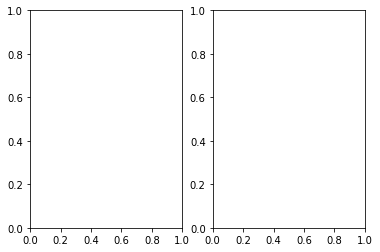

In [50]:
fig,axs = plt.subplots(1,2)
axs[0].scatter(Fmin_range, grs_4d5)
axs[0].axhline(y=max_grs[4.5],color='red',ls='--')

axs[1].scatter(Fmin_range, grs_5)
axs[1].axhline(y=max_grs[5],color='red',ls='--')

In [ ]:
max_grs

# Estimate Amin of GLCpts